In [52]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def xy2ak(x, y, v0, vf):
    """Convert xy positions to acceleration-curvature actions."""
    num_pts = len(x)

    # Numerically differentiate to determine path length of each segment
    dx = np.diff(x)
    dy = np.diff(y)
    ds = (dx**2 + dy**2) ** 0.5

    # Progress
    s = np.hstack([0.0, np.cumsum(ds)])

    # Total path length
    s_tot = s[-1]

    # Constant acceleration
    a = (vf**2 - v0**2) / (2 * s_tot)

    # Time series
    t = ((v0**2 + 2 * a * s) ** 0.5 - v0) / a

    # Acceleration; already calculated
    a_out = a * np.ones(num_pts - 1)

    # Use differential flatness to find curvature.
    dt = np.diff(t)

    vx = dx / dt
    vy = dy / dt

    dvx = np.diff(vx)
    dvy = np.diff(vy)
    dvx = np.hstack([dvx[0], dvx, dvx[-1]])
    dvy = np.hstack([dvy[0], dvy, dvy[-1]])
    dvx = (dvx[:-1] + dvx[1:]) / 2
    dvy = (dvy[:-1] + dvy[1:]) / 2

    ax = dvx / dt
    ay = dvy / dt

    k_out = (vx * ay - vy * ax) / ((vx**2 + vy**2) ** (3 / 2))

    return a_out, k_out, t


def resample(a, k, t, num_pts: int):
    t_new = np.linspace(0, t[-1], num_pts)

    ta = (t[1:] + t[:-1]) / 2
    ta_new = (t_new[1:] + t_new[:-1]) / 2
    a_new = np.interp(ta_new, ta, a)
    k_new = np.interp(ta_new, ta, k)
    return a_new, k_new, t_new

In [54]:
from abc import ABC, abstractmethod

In [55]:
A = np.array([
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 2, 0, 0],
    [1, 1, 1, 1, 1, 1],
    [5, 4, 3, 2, 1, 0],
    [20, 12, 6, 2, 0, 0],
])

In [56]:
Ainv = np.linalg.inv(A)
Ainv

array([[ -6. ,  -3. ,  -0.5,   6. ,  -3. ,   0.5],
       [ 15. ,   8. ,   1.5, -15. ,   7. ,  -1. ],
       [-10. ,  -6. ,  -1.5,  10. ,  -4. ,   0.5],
       [  0. ,   0. ,   0.5,   0. ,   0. ,   0. ],
       [  0. ,   1. ,   0. ,   0. ,   0. ,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

In [ ]:
class Steer:
    @classmethod
    @abstractmethod
    def steer_xy(cls, start, goal, num_pts: int):
        """Steer an xy trajectory."""

    @classmethod
    def states2bcs(cls, start, goal):
        # unpack
        x0, y0, yaw_0, v0 = start
        xf, yf, yaw_f, vf = goal

        # xy component velocities
        vx0 = v0 * np.cos(yaw_0)
        vy0 = v0 * np.sin(yaw_0)

        vxf = vf * np.cos(yaw_f)
        vyf = vf * np.sin(yaw_f)

        # bcs
        x_bc = np.array([x0, vx0, xf, vxf])
        y_bc = np.array([y0, vy0, yf, vyf])
        return x_bc, y_bc

    @classmethod
    def steer(cls, start, goal, action_length: int):
        x, y = cls.steer_xy(start, goal, num_pts=(2 * action_length)+1)
        v0 = start[3]
        vf = goal[3]
        a, k, t = xy2ak(x, y, v0, vf)
        a, k, t = resample(a, k, t, num_pts=action_length+1)
        return a, k, t



class CubicSteer(Steer):

    @classmethod
    def bc2coeffs(cls, bc):
        """Convert boundary condition to polynomial coefficients in decreasing powers."""
        # unpack
        x0, v0, xf, vf = bc
        # explicit matrix-vector multiplication
        return np.array(
            [
                2 * (x0 - xf) + (v0 + vf),
                3 * (xf - x0) - (2 * v0 + vf),
                v0,
                x0,
            ]
        )

    @classmethod
    def steer_xy(cls, start, goal, num_pts: int):
        x_bc, y_bc = cls.states2bcs(start, goal)

        x_coeffs = cls.bc2coeffs(x_bc)
        y_coeffs = cls.bc2coeffs(y_bc)

        u = np.linspace(0, 1, num_pts)

        u0 = np.ones(num_pts)
        u1 = u
        u2 = u**2
        u3 = u**3

        x = x_coeffs[0] * u3 + x_coeffs[1] * u2 + x_coeffs[2] * u1 + x_coeffs[3] * u0
        y = y_coeffs[0] * u3 + y_coeffs[1] * u2 + y_coeffs[2] * u1 + y_coeffs[3] * u0

        return x, y


class QuinticSteer(Steer):
    @classmethod
    def bc2coeffs(cls, bc):
        """Convert boundary condition to polynomial coefficients in decreasing powers."""
        x0, v0, xf, vf = bc
        return np.array(
            [
                6 * (xf - x0) - 3 * (v0 + vf),
                15 * (x0 - xf) + 8 * v0 + 7 * vf,
                10 * (xf - x0) - 6 * v0 - 4 * vf,
                0.0,
                v0,
                x0,
            ]
        )


    @classmethod
    def steer_xy(cls, start, goal, num_pts: int):
        x_bc, y_bc = cls.states2bcs(start, goal)
        x_coeffs = cls.bc2coeffs(x_bc)
        y_coeffs = cls.bc2coeffs(y_bc)

        u = np.linspace(0, 1, num_pts)
        # Precompute powers of u
        u0 = np.ones(num_pts)
        u1 = u
        u2 = u**2
        u3 = u**3
        u4 = u**4
        u5 = u**5

        x = x_coeffs[0] * u5 + x_coeffs[1] * u4 + x_coeffs[2] * u3 + x_coeffs[3] * u2 + x_coeffs[4] * u1 + x_coeffs[5] * u0
        y = y_coeffs[0] * u5 + y_coeffs[1] * u4 + y_coeffs[2] * u3 + y_coeffs[3] * u2 + y_coeffs[4] * u1 + y_coeffs[5] * u0

        return x, y


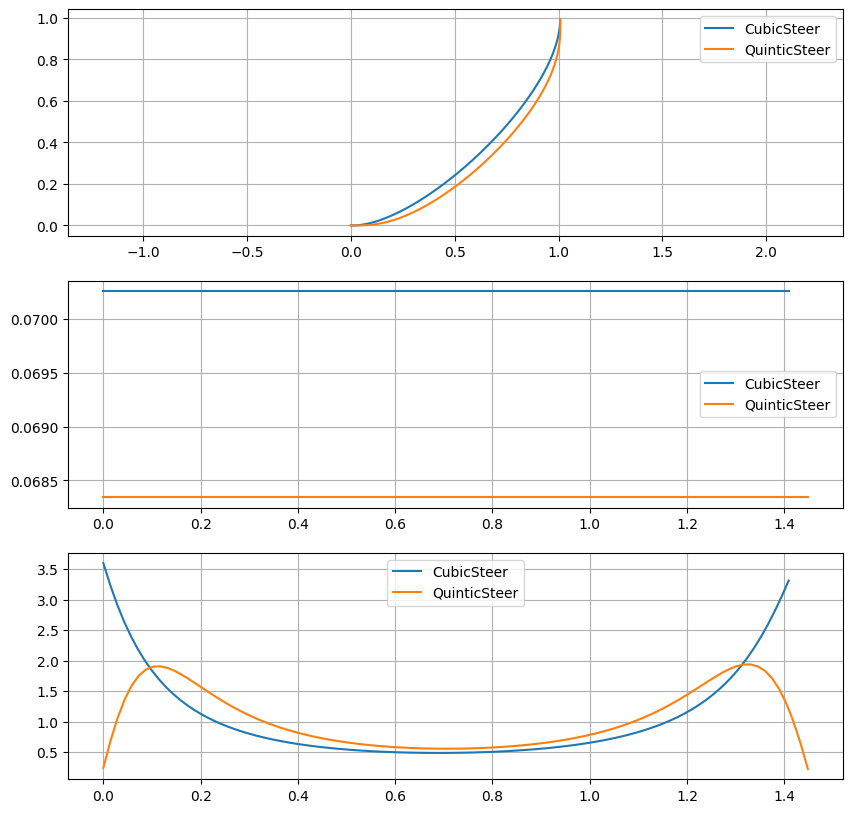

In [62]:
# x, y, yaw, v
# start = np.array([0.0, 0.0, 0.0, 1.0])
# goal = np.array([4.0, 0.2, np.pi/8, 2.0])
start = np.array([0.0, 0.0, 0.0, 1.0])
goal = np.array([1.0, 1.0, 1.6, 1.1])

fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

for steer_cls in [CubicSteer, QuinticSteer]:
    steer_cls_name = steer_cls.__name__
    acc, kurv, t = steer_cls.steer(start, goal, action_length=100)
    actions = np.array([acc, kurv]).T

    # rollout
    dt = np.mean(np.diff(t))

    states = [start]

    for i in range(len(t)-1):
        state = states[i]
        action = actions[i]
        x, y, yaw, v = state
        a, k = action
        state_new = state + dt * np.array([v * np.cos(yaw), v * np.sin(yaw), v * k, a])
        states.append(state_new)
    states = np.array(states)

    axs[0].plot(states[:, 0], states[:, 1], label=steer_cls_name)
    axs[1].plot(t[:-1], acc, label=steer_cls_name)
    axs[2].plot(t[:-1], kurv, label=steer_cls_name)

for ax in axs:
    ax.grid()
    ax.legend()

axs[0].axis("equal")

plt.show()

In [59]:
# # Numerically differentiate to determine path length of each segment
# dx = np.diff(x)
# dy = np.diff(y)
# ds = (dx**2 + dy**2)**0.5

# # Time derivatives in x and y
# vx_poly = np.polyder(x_poly)
# vy_poly = np.polyder(y_poly)
# ax_poly = np.polyder(vx_poly)
# ay_poly = np.polyder(vy_poly)

# vx = vx_poly(u)
# vy = vy_poly(u)

# v = (vx**2 + vy**2)**0.5

# ax = ax_poly(u)
# ay = ay_poly(u)


# # Differential flatness

# # Acceleration
# a = (vx * ax + vy * ay) / v
# a = (a[1:] + a[:-1]) / 2

# # Curvature
# k = (vx * ay - vy * ax) / (v**3)
# k = (k[1:] + k[:-1]) / 2

In [60]:
# va = (v[1:] + v[:-1]) / 2
# dt = ds / va

# t = np.hstack([0.0, np.cumsum(dt)])
# t_tot = np.sum(dt)
# print(t_tot)

# fig, axs = plt.subplots(nrows=7, sharex=True, figsize=(10, 10))
# axs[0].plot(t, x, label="x")
# axs[1].plot(t, y, label="y")
# axs[2].plot(t[:-1], k, label="k")
# axs[3].plot(t, vx, label="vx")
# axs[4].plot(t, vy, label="vy")
# axs[5].plot(t, v, label="v")
# axs[6].plot(t[:-1], a, label="a")
# for ax in axs:
#     ax.grid()
#     ax.legend()
# plt.show()

NameError: name 'x_new' is not defined

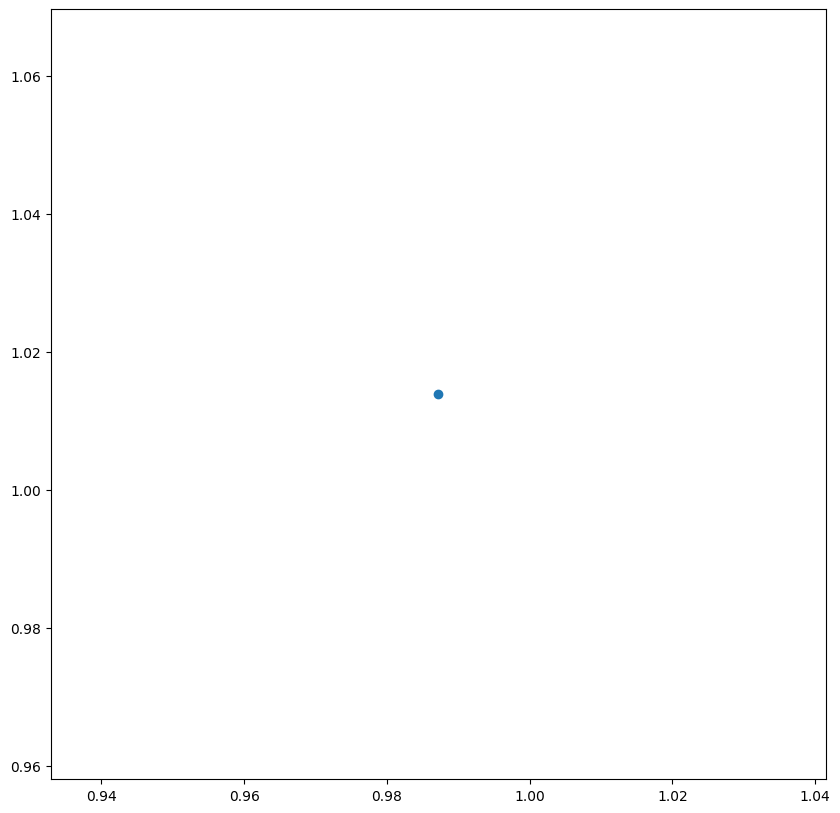

In [61]:
plt.subplots(figsize=(10, 10))
plt.plot(x, y, marker='o')
plt.plot(x_new, y_new, marker='x')
plt.axis("equal")
plt.grid()
plt.show()

2.3838932060927904


ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

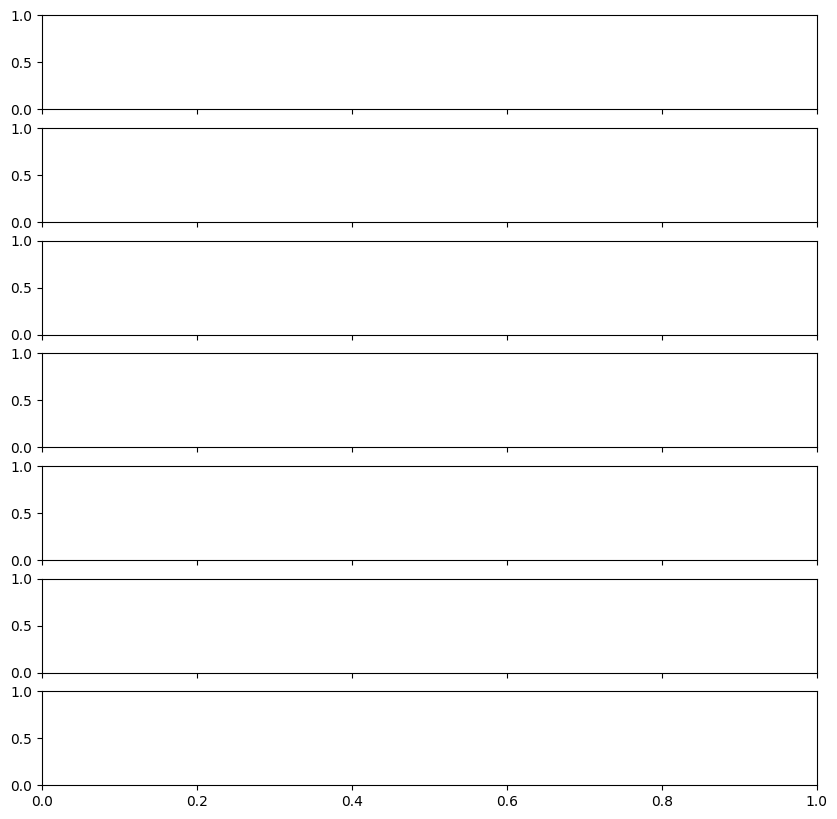

In [ ]:
print(t_tot)

fig, axs = plt.subplots(nrows=7, sharex=True, figsize=(10, 10))
axs[0].plot(t, x, label="x")
axs[1].plot(t, y, label="y")
axs[2].plot(t[:-1], k, label="k")
axs[2].plot(t_new[:-1], k_new, label="k_new")
axs[3].plot(t[:-1], vx, label="vx")
axs[4].plot(t[:-1], vy, label="vy")
axs[5].plot(t, v, label="v")
# axs[5].plot(t[:-1], (vx**2+vy**2)**0.5, label="v_alt")
axs[6].plot(t[:-1], a, label="a")
axs[6].plot(t_new[:-1], a_new, label="a_new")
for ax in axs:
    ax.grid()
    ax.legend()
plt.show()